<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Transformer/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D0%9C%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC_Transformers_%D0%9F%D0%B5%D1%80%D0%B5%D0%B2%D0%BE%D0%B4%D1%87%D0%B8%D0%BA_ru_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создать полную архитектуру трансформера и обучить модель для перевода русского текста на английский. Используем базу ted_hrlr_translate/ru_to_en из tfds.

Добиться более-менее адекватного перевода текста.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time, gc, os, gdown, shutil, zipfile
import numpy as np
from google.colab import files
from tensorflow import keras
from tensorflow.keras import utils
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных
data, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)
train_data_start, val_data, test_data = data['train'], data['validation'], data['test']

# Расширение тренировочного набора данных
train_data = train_data_start.concatenate(test_data)

# Использование тестового набора данных в качестве валидационного
#val_data = test_data

train_size = tf.data.experimental.cardinality(train_data).numpy()
val_size = tf.data.experimental.cardinality(val_data).numpy()

print(f"\nРазмер обучающего набора: {train_size} элементов")
print(f"Размер валидационного набора: {val_size} элементов")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/208106 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteEC4DGE/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/4805 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteEC4DGE/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/5476 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incompleteEC4DGE/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.

Размер обучающего набора: 213582 элементов
Размер валидационного набора: 4805 элементов


In [ ]:
# Вывод случайных пар предложений для каждого набора данных

# количество выводимых пар
cnt = 2

def print_random(dataset, buffer_size, dataset_name):
    print(f"\nСлучайные пары предложений из {dataset_name}:\n")
    data_set = dataset.shuffle(buffer_size)
    for ru, en in data_set.take(cnt):
        print("Русский: ", ru.numpy().decode('utf-8'))
        print("Английский: ", en.numpy().decode('utf-8'))
        print("")

print_random(train_data, train_size, "Обучающего набора")
print_random(val_data, val_size, "Валидационного набора")


Случайные пары предложений из Обучающего набора:

Русский:  утешение , которое музыка дала мне , было просто неописуемым . музыка по-настоящему открыла мне глаза , полностью изменила моё отношение к жизни и освободила меня от давления , вызванного стремлением стать успешной скрипачкой .
Английский:  the comfort the music gave me was just indescribable , and it was a real eye-opening experience for me too , and it totally changed my perspective on life and set me free from the pressure of becoming a successful violinist .

Русский:  мы можем профильтровать наши данные и увидеть , например , трёхмерную структуру растительности и зданий или можем использовать информацию о химическом составе для того чтобы оценить насколько быстро растут растения в тот момент , когда мы пролетаем над ними .
Английский:  we can slice through our data and see , for example , the 3d structure of the vegetation and the buildings , or we can use the chemical information to actually figure out how fast the plan

In [ ]:
# Создание токенизаторов

tokenizer_ru = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (ru.numpy() for ru, _ in train_data), target_vocab_size=2**14)

tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for _, en in train_data), target_vocab_size=2**14)

In [ ]:
# Проверим точность токенизации

# Функция для токенизации и детокенизации
def encode_decode(text, tokenizer):
    encoded = tokenizer.encode(text)
    decoded = tokenizer.decode(encoded)
    return decoded

# Функция для проверки совпадений
def check_matches(dataset):
    matching_pairs = 0
    total_pairs = 0
    for ru, en in dataset:
        ru = ru.numpy().decode('utf-8')
        en = en.numpy().decode('utf-8')

        restored_ru = encode_decode(ru, tokenizer_ru)
        restored_en = encode_decode(en, tokenizer_en)

        if ru == restored_ru and en == restored_en:
            matching_pairs += 1
        total_pairs += 1
    return matching_pairs, total_pairs

# Проверка совпадений для каждого набора данных
matching_pairs_train, total_pairs_train = check_matches(train_data)
matching_pairs_val, total_pairs_val = check_matches(val_data)

# Вывод результатов
print(f"Train Data - Количество совпадающих пар: {matching_pairs_train} из {total_pairs_train}")
print(f"Validation Data - Количество совпадающих пар: {matching_pairs_val} из {total_pairs_val}")

Train Data - Количество совпадающих пар: 213582 из 213582
Validation Data - Количество совпадающих пар: 4805 из 4805


In [ ]:
# Начинаем собирать трансформер. Определим вспомогательные функции, классы компонентов модели трансформера

# Позиционное кодирование
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # Применяем sin к четным индексам в массиве (2i)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Применяем cos к нечетным индексам (2i+1)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

'''
Класс CustomMultiHeadAttention модели одновременно обращает внимание на информацию из разных подпространств представления.
- Создание плотных слоев для Q (Query), K (Key), V (Value).
- Разделение данных на 'головы' для многоголового внимания.
- Применение масштабированного скалярного произведения в качестве механизма внимания.
- Объединение результатов от разных голов и передача их через плотный слой для получения окончательного результата.
'''
@tf.keras.utils.register_keras_serializable()
class CustomMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(CustomMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0  # Убедимся, что d_model делится на num_heads

        self.depth = d_model // self.num_heads  # Глубина каждой головы

        self.wq = tf.keras.layers.Dense(d_model)  # Плотный слой для Query
        self.wk = tf.keras.layers.Dense(d_model)  # Плотный слой для Key
        self.wv = tf.keras.layers.Dense(d_model)  # Плотный слой для Value

        self.dense = tf.keras.layers.Dense(d_model)  # Выходной плотный слой

    def get_config(self):
        config = super(CustomMultiHeadAttention, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def split_heads(self, x, batch_size):
        """Разделение последней размерности на (num_heads, depth).
        Перестановка размерности результата для формата (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        """Вычисление взвешенного внимания."""
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # Масштабирование
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Добавление маски к масштабированным тензорам
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # softmax применяется по последней оси (seq_len_k), так что оценки внимания суммируются в 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

        return output, attention_weights

'''
Класс EncoderLayer представляет один слой кодировщика в архитектуре трансформера.
Состоит из подслоев многослойного внимания (CustomMultiHeadAttention) и полносвязного feed-forward.
Применяет residual connections и нормализацию слоев.
'''
@tf.keras.utils.register_keras_serializable()
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha = CustomMultiHeadAttention(d_model, num_heads)  # Многослойное внимание
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)  # Feed-forward сеть
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Нормализация слоя
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Нормализация слоя
        self.dropout1 = tf.keras.layers.Dropout(rate)  # Dropout для многослойного внимания
        self.dropout2 = tf.keras.layers.Dropout(rate)  # Dropout для feed-forward сети

    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def point_wise_feed_forward_network(self, d_model, dff):
        """Возвращает модель feed-forward сети."""
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # Первый слой с активацией ReLU
            tf.keras.layers.Dense(d_model)  # Второй слой
        ])

    def call(self, x, training, mask):
        # Многослойное внимание
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Добавляем residual connection и применяем нормализацию
        # Feed-forward сеть
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Добавляем residual connection и применяем нормализацию
        return out2

'''
Класс DecoderLayer включает два блока многослойного внимания (CustomMultiHeadAttention) и один полносвязный feed-forward network.
Первый блок MHA используется для обработки входящего сигнала с маской, предотвращающей "просмотр" в будущее в последовательности.
Второй блок MHA используется для внимания к выходу кодировщика, для помощи декодеру сфокусироваться на соответствующих частях входной последовательности.
Полносвязная сеть используется для дальнейшей обработки сигнала.
Оба блока внимания и полносвязный слой снабжены residual connections и нормализацией.
'''
@tf.keras.utils.register_keras_serializable()
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha1 = CustomMultiHeadAttention(d_model, num_heads)  # Первый блок многослойного внимания
        self.mha2 = CustomMultiHeadAttention(d_model, num_heads)  # Второй блок многослойного внимания
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)  # Полносвязная сеть
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Нормализация слоя
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Нормализация слоя
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Нормализация слоя
        self.dropout1 = tf.keras.layers.Dropout(rate)  # Dropout для первого блока многослойного внимания
        self.dropout2 = tf.keras.layers.Dropout(rate)  # Dropout для второго блока многослойного внимания
        self.dropout3 = tf.keras.layers.Dropout(rate)  # Dropout для полносвязной сети

    def get_config(self):
        config = super(DecoderLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def point_wise_feed_forward_network(self, d_model, dff):
        """Возвращает модель feed-forward сети."""
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # Первый слой с активацией ReLU
            tf.keras.layers.Dense(d_model)  # Второй слой
        ])

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # Первый блок многослойного внимания (с масками)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        # Второй блок многослойного внимания (с маской padding и выходами кодировщика)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        # Полносвязная сеть
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

'''
Класс Encoder представляет собой энкодер в архитектуре трансформера, состоящий из стека слоев EncoderLayer.
Включает в себя слой embedding и позиционное кодирование.

Обрабатываем входные данные, применяя embedding и позиционное кодирование, а затем последовательно проходим через слои декодера.
Каждый слой декодера получает выходные данные предыдущего слоя, а также выходные данные из слоев кодировщика.
Это позволяет декодеру учитывать как входную, так и выходную информацию при генерации следующего токена.
'''
@tf.keras.utils.register_keras_serializable()
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.input_vocab_size = input_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size': self.input_vocab_size,
            'maximum_position_encoding': self.maximum_position_encoding,
            'rate': self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # Добавление embedding и позиционного кодирования.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)

'''
Класс Decoder состоит из множества слоев DecoderLayer и включает в себя слой embedding и позиционное кодирование.
'''
@tf.keras.utils.register_keras_serializable()
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.target_vocab_size = target_vocab_size
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'target_vocab_size': self.target_vocab_size,
            'maximum_position_encoding': self.maximum_position_encoding,
            'rate': self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

'''
Класс Transformer представляет полную модель трансформера из энкодера, декодера и окончательного плотного слоя для генерации вывода.
'''
@keras.saving.register_keras_serializable() # декоратор для загрузки ранее обученной модели
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.pe_input = pe_input
        self.pe_target = pe_target
        self.rate = rate
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def get_config(self):
        config = super(Transformer, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size': self.input_vocab_size,
            'target_vocab_size': self.target_vocab_size,
            'pe_input': self.pe_input,
            'pe_target': self.pe_target,
            'rate': self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [ ]:
# Параметры модели
num_layers = 2
d_model = 256
dff = 1024
num_heads = 4 # d_model должно нацело делиться на num_heads
BATCH_SIZE = 128
input_vocab_size = tokenizer_ru.vocab_size + 2  # Учитываем специальные токены <start> и <end>
target_vocab_size = tokenizer_en.vocab_size + 2  # Учитываем специальные токены <start> и <end>
dropout_rate = 0.1

# Создание экземпляра модели
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)


In [ ]:
# Определение расписания скорости обучения
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=(train_size/BATCH_SIZE)//3, **kwargs):
    super(CustomSchedule, self).__init__(**kwargs)
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {'d_model': self.d_model.numpy(), 'warmup_steps': self.warmup_steps}
  @classmethod
  def from_config(cls, config):
    return cls(**config)

learning_rate = CustomSchedule(d_model)

# Компиляция модели
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_sum(loss_ * mask) / tf.reduce_sum(mask)

transformer.compile(optimizer=optimizer, loss=loss_function)


In [ ]:
# Подготовка данных для подачи в модель

def encode(ru, en):
    ru = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(ru.numpy()) + [tokenizer_ru.vocab_size+1]
    en = [tokenizer_en.vocab_size] + tokenizer_en.encode(en.numpy()) + [tokenizer_en.vocab_size+1]
    return ru, en

def tf_encode(ru, en):
    result_ru, result_en = tf.py_function(encode, [ru, en], [tf.int64, tf.int64])
    result_ru.set_shape([None])
    result_en.set_shape([None])
    return result_ru, result_en

train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_size).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_data.map(tf_encode)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))

In [ ]:
# Готовимся к обучению модели

# Определение функции маскирования для padding и look-ahead
'''
Функции масок для входных данных в модель для обеспечения корректной работы механизмов внимания в модели трансформера.
Эти функции создают маски для учета padding в последовательностях и для look-ahead предотвращения "заглядывания" в будущее при генерации последовательности в декодере.
'''

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# Определение функции, которая будет фильтровать применяемую маску во время обучения
def create_masks(inp, tar):
    # Маска для кодировщика
    enc_padding_mask = create_padding_mask(inp)

    # Маски для декодировщика
    dec_padding_mask = create_padding_mask(inp)

    # Маска look-ahead для предсказаний
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [ ]:
'''
Процесс обучения c сохранением состояния модели после каждой эпохи
сделаем с явным циклом обучения без использования метода fit
'''
EPOCHS = 25  # Количество эпох обучения
new_train = False

if new_train == False:
  EPOCHS = 5

# Путь и архив ранее обученной модели на тех же параметрах
#url_model = 'https://drive.google.com/uc?id=1KL0hbEW4IQt85BI3uX9yY2fsKJ-HTYPF'
#file_model = 'translate_transformer.zip'

# Инициализируем состояние для потерь и точности
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Инициализация списков для хранения данных о потерях и точности
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Инициализация Checkpoint и CheckpointManager
checkpoint_path = './checkpoint'
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# Восстановление последнего чекпоинта или ранее обученной модели
if ckpt_manager.latest_checkpoint and new_train == False:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Последний чекпоинт восстановлен')
elif new_train == False:
    try:
        # Скачивание модели
        #gdown.download(url_model, file_model, quiet=True)
        # Авторизация и создание клиента Google Drive
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        # Загрузка файла
        file_id = '1xhATMh3ViCCxBPyGvsMdo45QCWlhoe0h'
        downloaded = drive.CreateFile({'id': file_id})
        downloaded.GetContentFile('translate_transformer.zip')
        # Распаковка
        with zipfile.ZipFile('/content/translate_transformer.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/model')
        # Загрузка модели
        transformer = load_model('/content/model', custom_objects={
            'CustomMultiHeadAttention': CustomMultiHeadAttention,
            'EncoderLayer': EncoderLayer,
            'DecoderLayer': DecoderLayer,
            'Encoder': Encoder,
            'Decoder': Decoder,
            'Transformer': Transformer,
            'CustomSchedule': CustomSchedule,
            'loss_function': loss_function
        })
        !rm -rf sample_data
        !rm translate_transformer.zip
    except:
        pass

# Используем декоратор для автоматического создания и оптимизации графов вычислений в TensorFlow для функций обучения
@tf.function(reduce_retracing=True)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # используем динамическое вычисление градиентов, чтобы избежать переполнения памяти
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

@tf.function(reduce_retracing=True)
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    predictions, _ = transformer(inp, tar_inp, False, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)
    val_loss(loss)
    val_accuracy(tar_real, predictions)

# Основной цикл обучения
period_vizualisation = (train_size/BATCH_SIZE)//5
for epoch in range(EPOCHS):
    start = time.time()
    # Обучение (inp -> русский, tar -> английский)
    total_batches = len(train_dataset)
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        # Расчет и вывод прогресса
        if batch % period_vizualisation == 0 and batch != 0:
            elapsed = time.time() - start
            avg_time_per_batch = elapsed / batch
            remaining_batches = total_batches - batch
            estimated_time = avg_time_per_batch * remaining_batches
            # Преобразование оставшегося времени в hh:mm:ss
            hours, remainder = divmod(estimated_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            ETA = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
            print(f'Epoch {epoch + 1}/{EPOCHS}, Batch {batch}/{total_batches}, Loss: {train_loss.result():.4f}, Accuracy: {train_accuracy.result():.4f}, Время затрачено: {elapsed:.2f} сек, осталось: {ETA}')
            gc.collect() # почистим память

    train_losses.append(train_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy())

    # Валидация
    for (batch, (inp, tar)) in enumerate(val_dataset):
        val_step(inp, tar)

    val_losses.append(val_loss.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())
    gc.collect() # почистим память

    # Сохранение чекпоинта после завершения эпохи
    ckpt_save_path = ckpt_manager.save()
    print(f"Чекпоинт сохранен как '{ckpt_save_path}' после эпохи {epoch+1}")

    print(f'Epoch {epoch + 1}, Loss: {train_loss.result():.4f}, Accuracy: {train_accuracy.result():.4f}, Val_Loss: {val_loss.result():.4f}, Val_Accuracy: {val_accuracy.result():.4f}')
    print(f'Время на выполнение эпохи: {time.time() - start:.2f} сек\n')

Последний чекпоинт восстановлен
Epoch 1/5, Batch 333/1669, Loss: 1.6210, Accuracy: 0.1601, Время затрачено: 108.95 сек, осталось: 00:07:17
Epoch 1/5, Batch 666/1669, Loss: 1.6432, Accuracy: 0.1581, Время затрачено: 213.61 сек, осталось: 00:05:21
Epoch 1/5, Batch 999/1669, Loss: 1.6610, Accuracy: 0.1572, Время затрачено: 318.09 сек, осталось: 00:03:33
Epoch 1/5, Batch 1332/1669, Loss: 1.6773, Accuracy: 0.1567, Время затрачено: 420.90 сек, осталось: 00:01:46
Epoch 1/5, Batch 1665/1669, Loss: 1.6895, Accuracy: 0.1567, Время затрачено: 523.19 сек, осталось: 00:00:01
Чекпоинт сохранен как './checkpoint/ckpt-11' после эпохи 1
Epoch 1, Loss: 1.6895, Accuracy: 0.1567, Val_Loss: 2.5372, Val_Accuracy: 0.1334
Время на выполнение эпохи: 550.30 сек

Epoch 2/5, Batch 333/1669, Loss: 1.6731, Accuracy: 0.1574, Время затрачено: 102.98 сек, осталось: 00:06:53
Epoch 2/5, Batch 666/1669, Loss: 1.6679, Accuracy: 0.1578, Время затрачено: 205.74 сек, осталось: 00:05:09
Epoch 2/5, Batch 999/1669, Loss: 1.6686

In [ ]:
# Сохраняем обученную модель
model_dir = './saved_model'
transformer.save(model_dir, save_format='tf')

In [ ]:
# Запакуем модель
zip_path = '/content/translate_transformer.zip'
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_dir)

'/content/translate_transformer.zip'

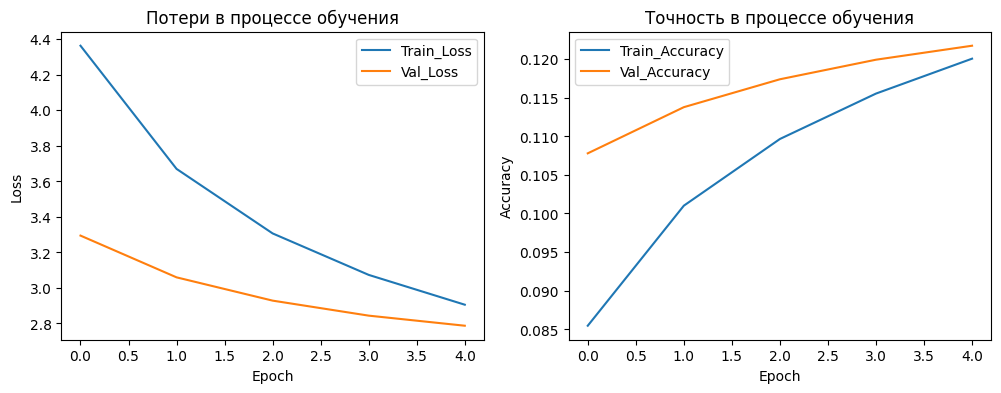

In [ ]:
# Визуализация процесса обучения
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train_Loss')
plt.plot(val_losses, label='Val_Loss')
plt.title('Потери в процессе обучения')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train_Accuracy')
plt.plot(val_accuracies, label='Val_Accuracy')
plt.title('Точность в процессе обучения')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

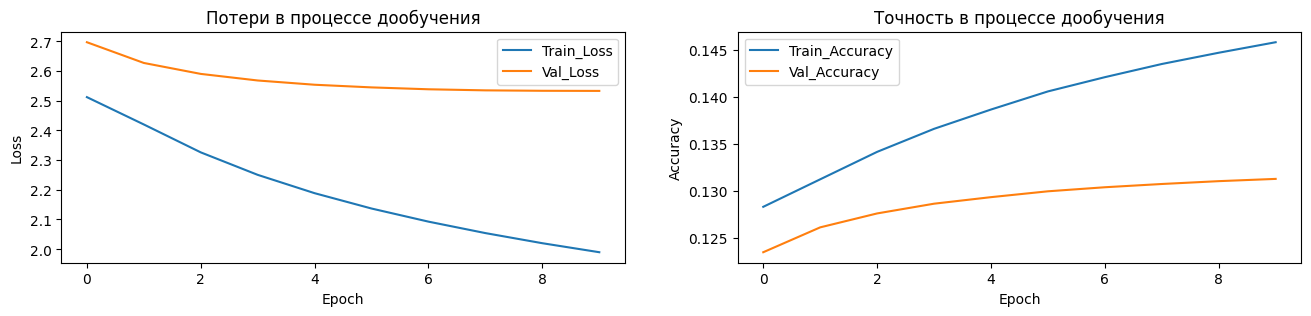

In [ ]:
# Визуализация процесса дообучения
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train_Loss')
plt.plot(val_losses, label='Val_Loss')
plt.title('Потери в процессе дообучения')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train_Accuracy')
plt.plot(val_accuracies, label='Val_Accuracy')
plt.title('Точность в процессе дообучения')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Скачаем обученную модель
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Загрузим нашу, ранее обученную модель

# Авторизация и создание клиента Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Загрузка файла
file_id = '1xhATMh3ViCCxBPyGvsMdo45QCWlhoe0h'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('translate_transformer.zip')
# Распаковка
with zipfile.ZipFile('/content/translate_transformer.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/model')
# Загрузка модели
transformer = load_model('/content/model', custom_objects={
    'CustomMultiHeadAttention': CustomMultiHeadAttention,
    'EncoderLayer': EncoderLayer,
    'DecoderLayer': DecoderLayer,
    'Encoder': Encoder,
    'Decoder': Decoder,
    'Transformer': Transformer,
    'CustomSchedule': CustomSchedule,
    'loss_function': loss_function
})
!rm -rf sample_data
!rm translate_transformer.zip

In [ ]:
# Функция для оценки перевода
def evaluate(inp_sentence):
    start_token = [tokenizer_ru.vocab_size]
    end_token = [tokenizer_ru.vocab_size + 1]

    # Добавление start и end токенов
    inp_sentence = start_token + tokenizer_ru.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # Так как цель - генерация текста, вывод начинается с английского токена начала последовательности.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    # Основной цикл перевода трансформером
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # Предсказания модели
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # Выбор последнего слова из вывода
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Если модель предсказывает токен конца, возвращаем результат
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # Конкатенация предсказанного слова с выводом и передача в модель как нового ввода
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

# Функция перевода
def translate(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result
                                            if i < tokenizer_en.vocab_size])
    print(f'{predicted_sentence}\n')

In [ ]:
print('Введите слово или фразу для перевода. Для выхода введите 'exit'.\n')

# Цикл пользовательского перевода
max_length = 100 # ограничение длины фразы для перевода
while True:
    try:
        sentence = input()
        if sentence.lower() == 'exit':  # проверка на команду для выхода
            break
        if sentence.strip():  # проверка на пустую строку
            translate(sentence)
    except KeyboardInterrupt:
        break
print('Работа завершена. Для продолжения запустите ячейку повторно.')


Введите слово или фразу для перевода. Для выхода введите 'exit'.

Оперативная память графического процессора
the answer is the perasavibrillah memory of the graphy .

Сколько времени займет решение этой задачи?
is it because of time going to take a solution to this problem ?

Удивительные варианты приходится видеть.
the simple possibility is that we have to see . right ?

Как с тобой общаться?
so you have to have an order of contact ?

Кто тебя научил так отвечать?
so you know , you have to say that ?

Напишите письмо маме.
okay , so this is what you call a post-dock .

Напишите письмо маме.
okay , so this is what you call a post-dock .

утешение , которое музыка дала мне , было просто неописуемым . музыка по-настоящему открыла мне глаза , полностью изменила моё отношение к жизни и освободила меня от давления , вызванного стремлением стать успешной скрипачкой .
the comfort that music gave me was just an insanity , the music really opened my eyes to me , completely changed my relationsh